In [1]:
# install packages if imports dont work

import numpy as np
import pandas as pd
import seaborn as sns
import os
from numpy.polynomial import polynomial as P
from matplotlib import pyplot as plt

#### Information about the data set:

Title: Inferring strategies from observations in long iterated prisoner’s dilemma experiments

Link: https://datadryad.org/stash/dataset/doi:10.5061%2Fdryad.37pvmcvmk

Game: Repeated PD randomly; matched partners

Payoff matrix:


| Player\Opponent | C        | D    |
| ------          | ----- | ---- |
| **C**           | (3, 3)     | (0, 4) |
| **D**           | (4, 0)     | (1, 1) |

In [2]:
# Setting working directory
print(f'Before={os.getcwd()}') 

path = 'C:\\Users\\1412r\\sciebo\\GuiltAndResponsibility'
os.chdir(path) # Set wd to \sciebo\GuiltAndResponsibility
print(f'After={os.getcwd()}')

Before=C:\Users\1412r\sciebo\GuiltAndResponsibility\Codes
After=C:\Users\1412r\sciebo\GuiltAndResponsibility


In [3]:
# Get csv data

#print(os.getcwd())
path = 'Data/PD_Data1/rand.csv'
df = pd.read_csv(path, header=0, delimiter=';')

#df.head()

In [4]:
# Housekeeping

drop_cols = ['time_php', 'time_js', 'treatment', 'context', 'prev', 'prev_player',  'prev_opp', 'session']
df.drop(columns=drop_cols, inplace=True)

In [5]:
# Checking how the dataset looks

print(f'The shape of df is {df.shape}\n')
print(df.groupby(['player']).count())
print(df.info())
df.describe()

The shape of df is (9600, 6)

                round  action_player  opponent  action_opponent  payoff
player                                                                 
s11n9usuario1     100            100       100              100     100
s11n9usuario10    100            100       100              100     100
s11n9usuario2     100            100       100              100     100
s11n9usuario3     100            100       100              100     100
s11n9usuario4     100            100       100              100     100
...               ...            ...       ...              ...     ...
s7m22usuario5     100            100       100              100     100
s7m22usuario6     100            100       100              100     100
s7m22usuario7     100            100       100              100     100
s7m22usuario8     100            100       100              100     100
s7m22usuario9     100            100       100              100     100

[96 rows x 5 columns]
<class 'pan

,round,payoff
count,9600.000000,9600.000000
mean,50.500000,1.570417
std,28.867574,1.421502
min,1.000000,0.000000
25%,25.750000,1.000000
50%,50.500000,1.000000
75%,75.250000,3.000000
max,100.000000,4.000000


1) 96 subjects with mostly 100 trials each
2) action_player is the dependent variable, payoff is one of the independent variables the other one is payoff of the opponent (calculated below)
3) No NaN values

4) Mean payoff is 1.57, closest to 1 in the payoff matrix, which is obtained by the combination of actions (D, D)

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Add column for the partner's payoff

df['payoff_opponent'] = df['payoff'] # Payoffs are same when both take the same action
df['payoff_opponent'].loc[(df['action_player']=='C') & (df['action_opponent']=='D')] = 4
df['payoff_opponent'].loc[(df['action_player']=='D') & (df['action_opponent']=='C')] = 0

In [8]:
df.head() 
#df.tail() # see last 5 rows

,round,player,action_player,opponent,action_opponent,payoff,payoff_opponent
0,1,s11n9usuario1,C,s11n9usuario10,C,3,3
1,2,s11n9usuario1,C,s11n9usuario10,D,0,4
2,3,s11n9usuario1,C,s11n9usuario7,C,3,3
3,4,s11n9usuario1,C,s11n9usuario8,D,0,4
4,5,s11n9usuario1,C,s11n9usuario7,C,3,3


The number of rows with equal payoffs is 5744


<AxesSubplot:>

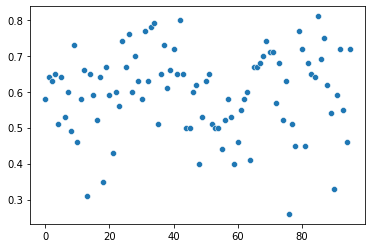

In [9]:
# Checking fraction of rows with equal payoffs

number_of_participants = len(df['player'].unique())
x = (df[df['payoff']==df['payoff_opponent']]).shape[0]
print(f'The number of rows with equal payoffs is {x}')

frac = (df[df['payoff']==df['payoff_opponent']].value_counts(subset=['player'])/df.value_counts(subset=['player']))
sns.scatterplot(y=frac, x=range(number_of_participants))

Again, atleast 1/3 of rows have equal payoff for both self and other for every participant (???(use it to extrapolate scaling factor?))

### Graphs (Player behaviour)

Plotting
1) probability of C used by the players (probability of D is 1 minus this number)
2) probability of CC (probability of CD is the number in (1) minus this number)
3) probability of DD (probability of DC 1 minus the number in (1) minus this number)

In [10]:
# PLayer wise frequency of action C and outcomes (C, C) and (D, D)

freq_table = pd.DataFrame(index=df['player'].unique(), columns=['C_freq', 'CC_freq', 'DD_freq'])

for i in df['player'].unique():
    freq_table.loc[i, 'C_freq']  = sum((df['action_player']=='C')&(df['player']==i))/sum(df['player']==i)
    freq_table.loc[i, 'CC_freq'] = sum((df['action_opponent']=='C')&(df['action_player']=='C')&(df['player']==i))/sum(df['player']==i)
    freq_table.loc[i, 'DD_freq'] = sum((df['action_opponent']=='D')&(df['action_player']=='D')&(df['player']==i))/sum(df['player']==i)
    freq_table.loc[i, 'CD_freq'] = sum((df['action_opponent']=='D')&(df['action_player']=='C')&(df['player']==i))/sum(df['player']==i)

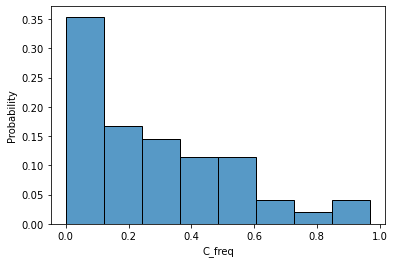

In [11]:
# Histogram of frequency of players playing C
ax = sns.histplot(x=freq_table['C_freq'], stat='probability')

<AxesSubplot:xlabel='CC_freq', ylabel='Probability'>

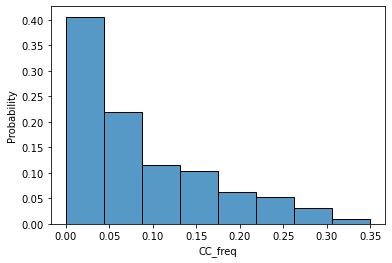

In [12]:
# Histogram of frequency of the outcome (C, C)
sns.histplot(x=freq_table['CC_freq'], stat='probability')

<AxesSubplot:xlabel='DD_freq', ylabel='Probability'>

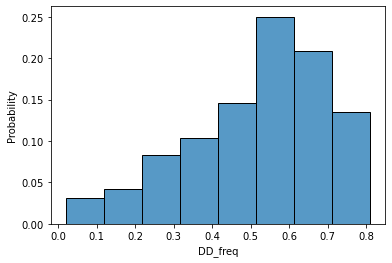

In [13]:
# Histogram of frequency of the outcome (D, D)
sns.histplot(x=freq_table['DD_freq'], stat='probability')

<AxesSubplot:xlabel='CD_freq', ylabel='Probability'>

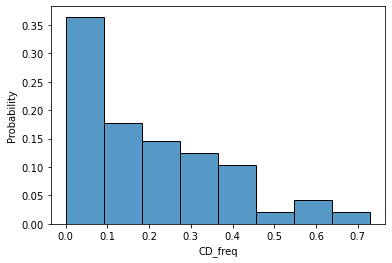

In [14]:
# Histogram of frequency of the outcome (C, D)
sns.histplot(x=freq_table['CD_freq'], stat='probability')

In [15]:
sum(freq_table['C_freq']<0.5)/96 # percentage of people who use C less than 50% of the time

0.78125

In [16]:
sum(freq_table['C_freq']==1)

0

In [17]:
sum(freq_table['C_freq']==0)

7

In [18]:
# Player wise distribution of action C

def make_freqplot(i):
    temp = pd.get_dummies(df[df['player']==i]['action_player'])
    temp['CumD'] = (temp['D'].cumsum())/sum(df['player']==i)
    
    sns.lineplot(x=temp.index, y=temp['CumD']).set(ylabel='Probability of choosing D', xlabel=i)

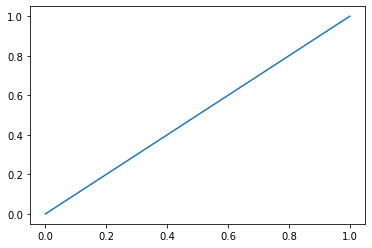

In [19]:
# Dummy graph to set the axis in the subsequent graphs
ax=sns.lineplot(x=np.linspace(0, 1, 100, endpoint=True), y=np.linspace(0, 1, 100, endpoint=True))

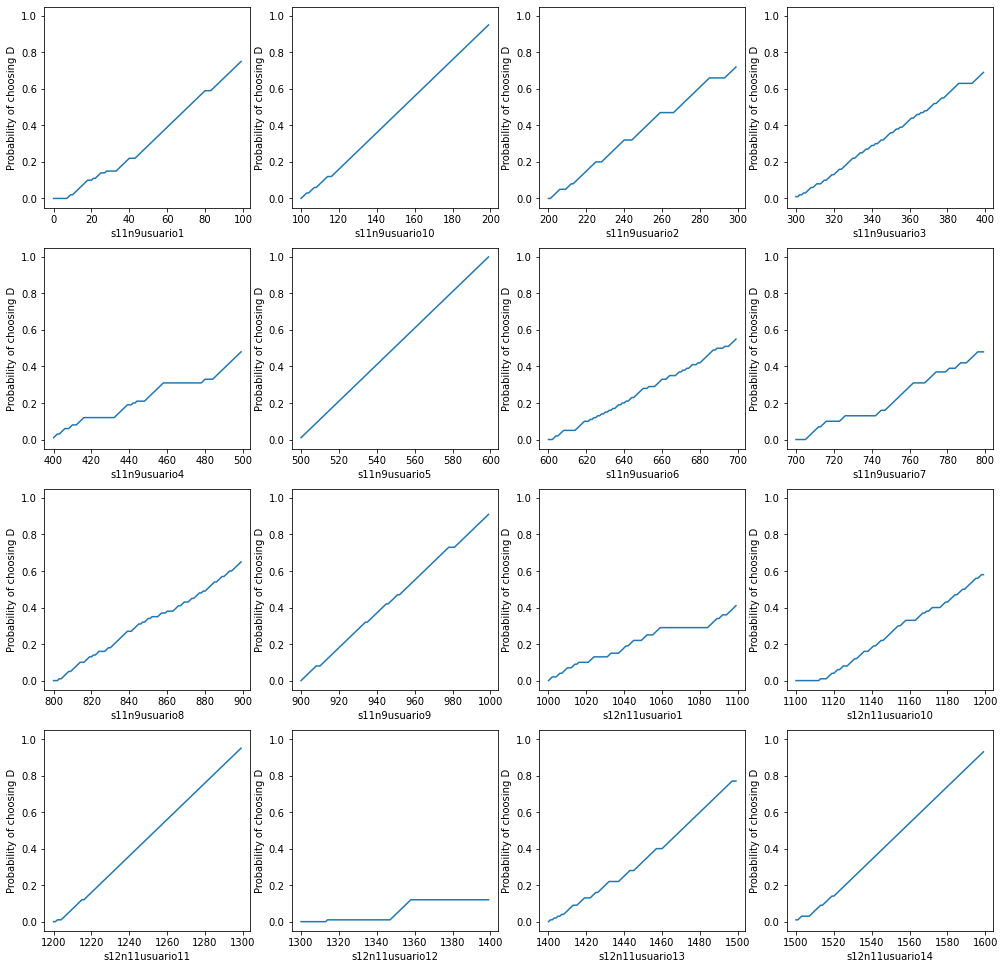

In [20]:
count = 1
no_of_cols = 4
no_of_rows = 4
players = np.array_split((df['player'].unique()), 6)

# Graph
plt.figure(figsize=(17, 17))
plt.title('Player wise probabilty of playing D wrt number of rounds for players 1-16')

for i in players[0]:
    plt.subplot(no_of_rows, no_of_cols, count, sharey=ax)
    make_freqplot(i)
    count+=1

plt.show()

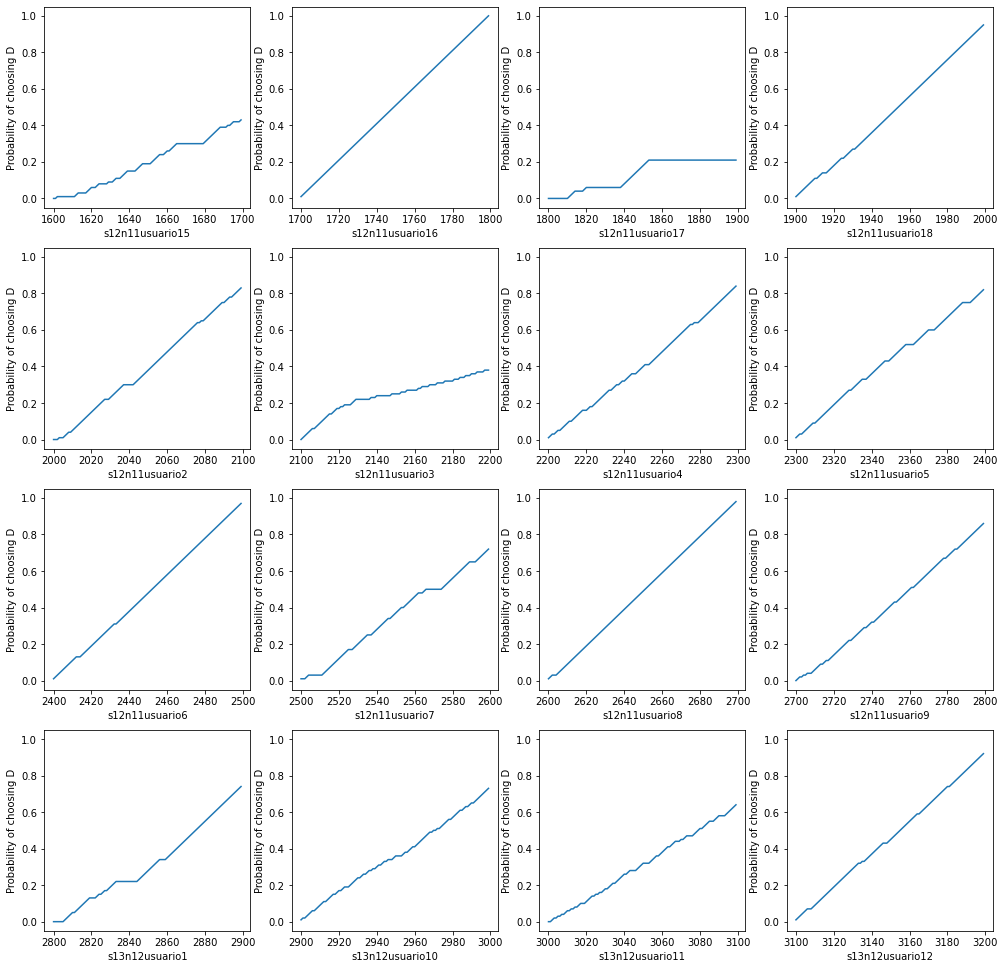

In [21]:
count = 1

# Graph
plt.figure(figsize=(17, 17))
plt.title('Player wise probabilty of playing D wrt number of rounds for players 17-32')

for i in players[1]:
    plt.subplot(no_of_rows, no_of_cols, count, sharey=ax)
    make_freqplot(i)
    count+=1

plt.show()

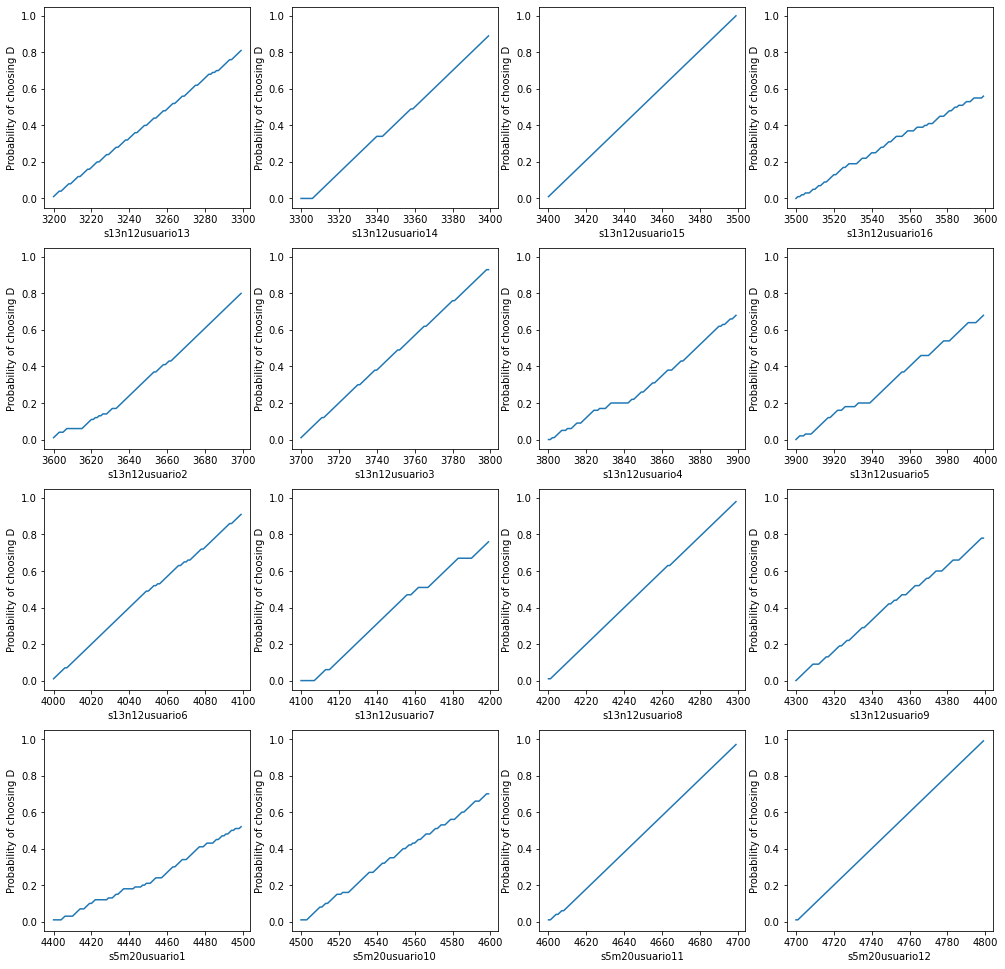

In [22]:
count = 1

# Graph
plt.figure(figsize=(17, 17))
plt.title('Player wise probabilty of playing D wrt number of rounds for players 33-48')

for i in players[2]:
    plt.subplot(no_of_rows, no_of_cols, count, sharey=ax)
    make_freqplot(i)
    count+=1

plt.show()

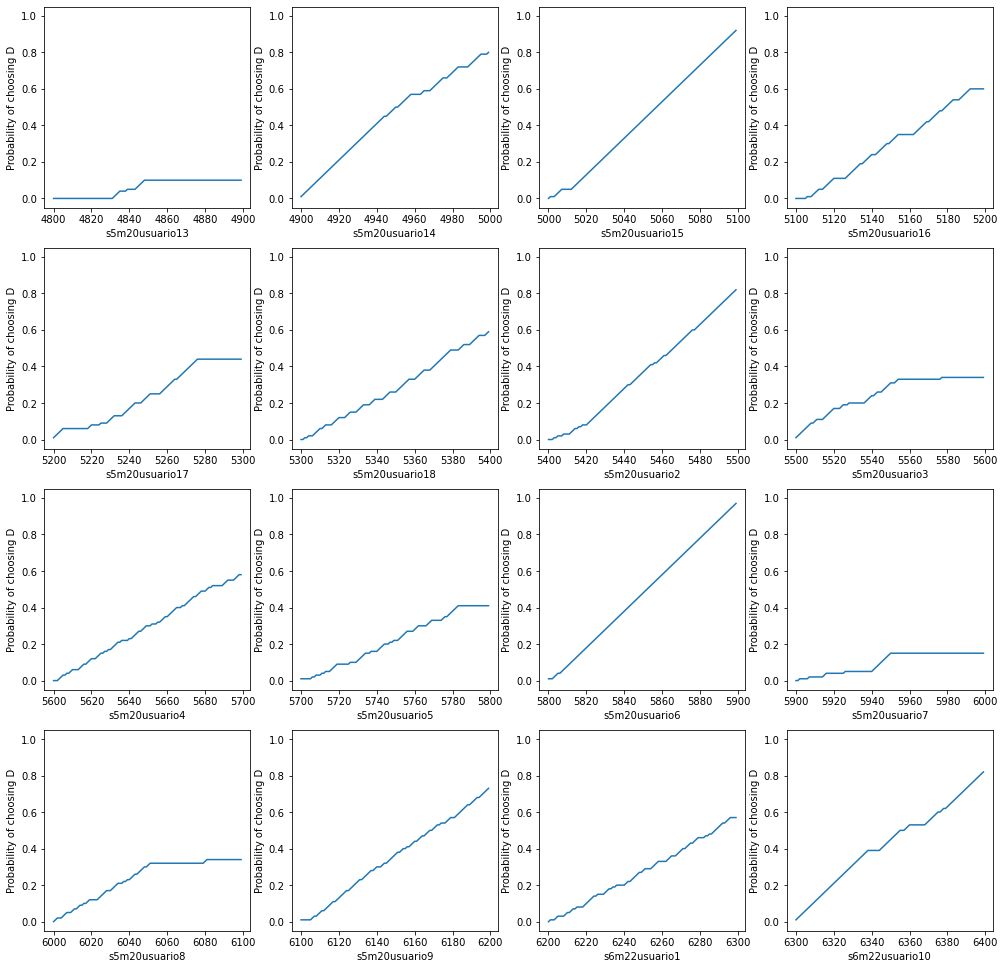

In [23]:
count = 1

# Graph
plt.figure(figsize=(17, 17))
plt.title('Player wise probabilty of playing D wrt number of rounds for players 49-64')

for i in players[3]:
    plt.subplot(no_of_rows, no_of_cols, count, sharey=ax)
    make_freqplot(i)
    count+=1

plt.show()

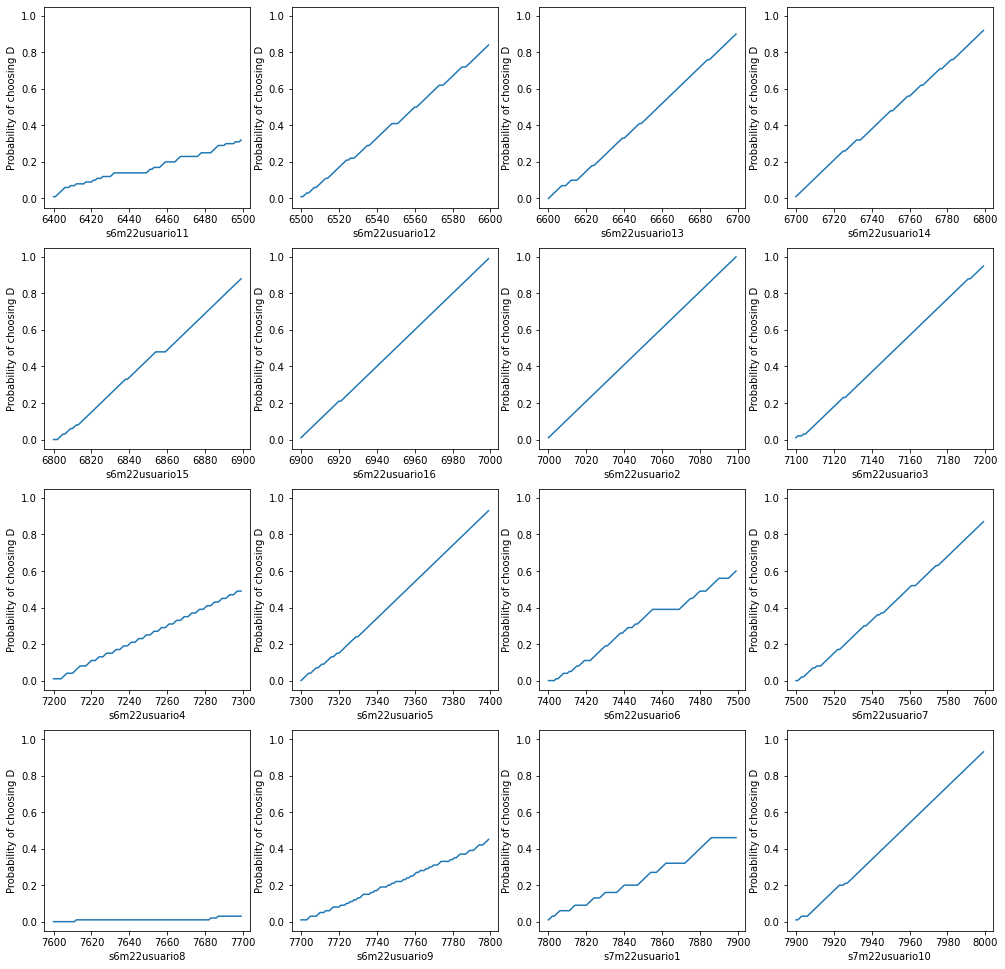

In [24]:
count = 1

# Graph
plt.figure(figsize=(17, 17))
plt.title('Player wise probabilty of playing D wrt number of rounds for players 65-80')

for i in players[4]:
    plt.subplot(no_of_rows, no_of_cols, count, sharey=ax)
    make_freqplot(i)
    count+=1

plt.show()

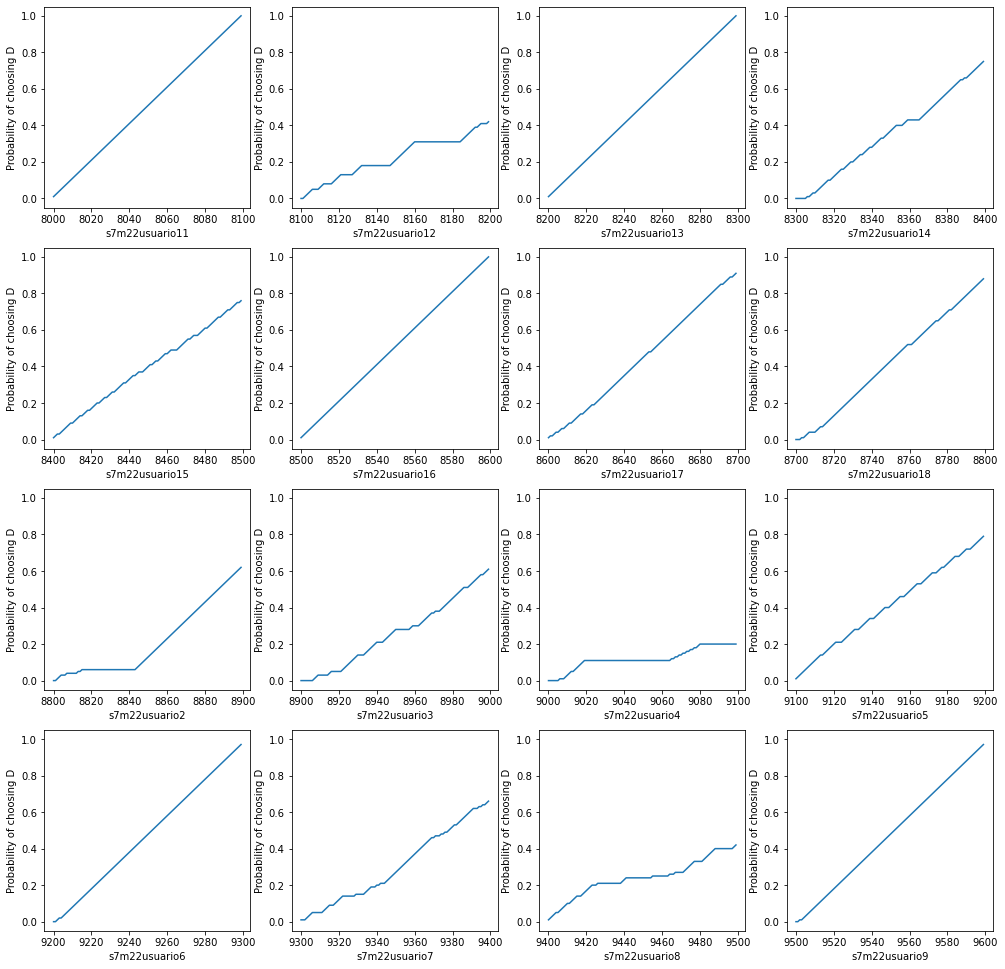

In [25]:
count = 1

# Graph
plt.figure(figsize=(17, 17))
plt.title('Player wise probabilty of playing D wrt number of rounds for players 81-96')

for i in players[5]:
    plt.subplot(no_of_rows, no_of_cols, count, sharey=ax)
    make_freqplot(i)
    count+=1

plt.show()

# Zero level Player

Payoff matrix:


| Player\Opponent | C        | D    |
| ------          | ----- | ---- |
| **C**           | $$(3, 3)$$     | $$(4\alpha_1, 4)$$ |
| **D**           | $$(4(1-\beta_1), 0)$$     | $$(1, 1)$$ |

#### (Change the table below into a graph, its better for visualization)
Best response of the player (format: (when opponent plays C, when opponent plays D)):

|  | $$\alpha < \frac{1}{4}$$      | $$\alpha > \frac{1}{4}$$   |
| ------          | ----- | ---- |
| **$$\beta < \frac{1}{4}$$**           | (D, D)     | (D, C) |
| **$$\beta > \frac{1}{4}$$**           | (C, D)     | (C, C) |

For 0 level player, belief about opponent's parameters: alpha = beta = 0. Thus, the opponent will play D. So the best response will be to play D if $\alpha$ is less than 1/4 and C otherwise. **(Checkpoint1: Assumption is that only beliefs about alpha and beta vary over levels not the strategy)**

In [26]:
# Grid parameters

steps = 11 ##### Input number of steps here
N = df.shape[0]

alpha_range = np.linspace(0, 1, steps, endpoint=True)
beta_range  = np.linspace(0, 1, steps, endpoint=True)
col = []

for alpha in alpha_range: 
    for beta in beta_range: 
        name = str(alpha), str(beta)
        col  = col + [name]

In [27]:
# Create empty dataframes
action = pd.DataFrame(index=df.index, columns=col)    # utility matrix
error  = pd.DataFrame(index=df.index, columns=col)     # error matrix

For now not dropping rows for actions with equal payoffs  **(Checkpoint2)**

In [28]:
# Calculating error matrix

for x in col:
    error[x] = action[x]==df['action_player'] # this is done differently wrt previous codes because here we compare string vs string (eg C vs C), while before we compared numbers and subtraction is supported only for numeric values
    
error = 1 - error # Converting to ones and zeros from trues and falses
error['player'] = df['player'] # Adding player column for easier future calculations
#error.head()

In [29]:
# Calculate average error for each participant

data = []

for i in df['player'].unique():
    sum_of_error = (error[error['player']==i].iloc[:,:-1]).sum() # summing over error rows where player == i and taking every column except the last (which is the name column) using iloc
    number_of_trials = (df['player']==i).sum()
    data = data + [sum_of_error/number_of_trials]
    
avg_error = pd.DataFrame(data=data)

#avg_error.head()

There was no need to square errors in this case because errors were not negative (only zeroes and ones)

#### Finding minimum error

Since in this case all error before $\alpha = 0.25$ are same and all after are same. Effectively, there are only two useful buckets of alpha. So, using only two buckets instead of 11 to plot

In [30]:
# Calculating fraction of players in the lower alpha bracket

frac = sum(avg_error.iloc[:, 0]<=0.5)/number_of_participants # sum of rows of first column of avg_error which are less than 0.5 divided by no of participants
frac # taking less than 0.5 because the other error is compliment of this (check avg_error df)

0.0

So 78% participants lie in the smaller alpha bracket

Text(0.5, 0, 'Error')

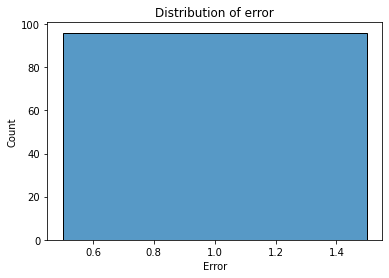

In [31]:
fig, ax = plt.subplots()

pt1 = sns.histplot(x=avg_error.iloc[:, 0], ax=ax) # when alpha is in the lower bracket
#pt2 = sns.histplot(x=avg_error.iloc[:, -1], ax=ax, color='red') # in the higher bracket
plt.title('Distribution of error')
plt.xlabel('Error')

# Level 1 PLayer

Level 1 players assume that everyone has the same parameter values, ie $\alpha_1=\alpha_2=\alpha$ and $\beta_1=\beta_2=\beta$

Payoff matrix:


| Player\Opponent | C        | D    |
| ------          | ----- | ---- |
| **C**           | $(3, 3)$     | $$(4\alpha, 4(1-\beta))$$ |
| **D**           | $$(4(1-\beta), 4\alpha)$$     | $$(1, 1)$$ |

If player 2 plays C, best response of player 1 is

$$
    \text{best response} = 
    \begin{cases}
        C & \mbox{if } \beta > 0.25\\
        D & \mbox{if } \beta < 0.25\\
        \{C, D\} & \mbox{if } \beta = 0.25
    \end{cases}
$$

And if player 2 plays D, best response of player 1 is

$$
    \text{best response} = 
    \begin{cases}
        C & \mbox{if } \alpha > 0.25\\
        D & \mbox{if } \alpha < 0.25\\
        \{C, D\} & \mbox{if } \alpha = 0.25
    \end{cases}
$$

Broadly there will be four types of players, low-$\alpha$ low-$\beta$ type, low-$\alpha$ high-$\beta$ type, high-$\alpha$ low-$\beta$ and high-$\alpha$ high-$\beta$ type. And each will have their own equilibrium strategy.

1) For the low-low type, playing D is the dominant strategyand for the high-high type, dominant strategy is C
2) For low-high and high-low types there are two pure strategy Nash equilibria and one mixed strategy.

Assume that the players choose actions such that the equilibrium with higher payoff is achieved. **(Checkpoint3)**

Now, for low-high type, the equilibria are (C, C) and (D, D), first gives the player a payoff of 3 and the second gives 1. So low-high type will play C. For high-low type, the equilibria are (C, D) and (D, C) which give respective payoffs, $4\alpha$ and $4(1-\beta)$. Thus, if $\alpha+\beta>1$ player will play C and the opponent will play D and vice versa in the other case.

### (Add this alpha-beta strategy graph using latex later)

In [32]:
# Create empty dataframes
action1 = pd.DataFrame(index=df.index, columns=col)    # utility matrix
error1  = pd.DataFrame(index=df.index, columns=col)    # error matrix

In [33]:
# Action Grid: C for beta > 0.25 and D for beta < 0.25 except when alpha + beta > 1 (no equality in 11 steps' case)

for i in range(len(col)):
    beta = float(col[i][1]) # convert beta (from column name) from string to float
    if beta > 0.25:
        action1.iloc[:, i] = 'C'
    if beta < 0.25:
        alpha = float(col[i][0])
        if (alpha+beta > 1): # if alpha > 0.75:
            action1.iloc[:, i] = 'C'
        if (alpha+beta < 1): # if alpha < 0.75:
            action1.iloc[:, i] = 'D'
        
#action1.head()

In [34]:
# Calculating error matrix

for x in col:
    error1[x] = action1[x]==df['action_player']
    
error1 = 1 - error1 # Converting to ones and zeros from trues and falses
error1['player'] = df['player'] # Adding player column for easier future calculations

#error1.head()

In [35]:
# Calculate average error for each participant

data = []

for i in df['player'].unique():
    sum_of_error     = (error1[error1['player']==i].iloc[:,:-1]).sum() # summing over error rows where player == i and taking every column except the last (which is the name column) using iloc
    number_of_trials = (df['player']==i).sum()
    data             = data + [sum_of_error/number_of_trials]
    
avg_error1 = pd.DataFrame(data=data)

#avg_error1.head()

In [36]:
# Minimise error

min_error1 = avg_error1.idxmin(axis=1) # gives the first pair where minimum error occurs
#min_error1

In [37]:
# Find indices with minimum error

s = avg_error1.eq(avg_error1.min(axis=1), axis=0) # dataframe of boolean wherever min occurs
min_error_indices = s.agg(lambda s: s.index[s].values, axis=1) # row wise aggregating indices of columns where true occurs
#min_error_indices

In [38]:
# Creating a dataframe of alphas and betas which give minimum error, for every player

min_param = pd.DataFrame(min_error_indices[0].tolist(), columns=['alpha', 'beta'])
min_param['player'] = 0

for i in min_error_indices.index:
    if i == min_error_indices.index.stop-1:
        break
    temp_df = pd.DataFrame(min_error_indices[i+1].tolist(), columns=['alpha', 'beta'])
    temp_df['player'] = i+1
    min_param = pd.concat([min_param, temp_df])
    
min_param.index = range(len(min_param))

#min_param

In [39]:
# Find player wise average alpha and beta

min_param['alpha'] = min_param['alpha'].astype(float) # conevrting type from string to float
min_param['beta']  = min_param['beta'].astype(float)   # conevrting type from string to float

final = min_param.groupby(by=['player']).mean() # grouping by mean wrt player

Text(0.5, 1.0, 'Mean Alpha')

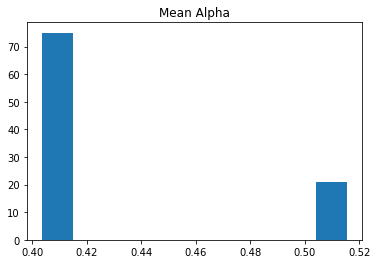

In [40]:
# PLotting frequency of mean alpha

plt.hist(final['alpha'])
plt.title('Mean Alpha')

Text(0.5, 1.0, 'Mean Beta')

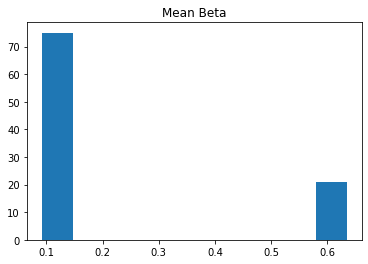

In [41]:
# PLotting frequency of mean beta

plt.hist(final['beta'])
plt.title('Mean Beta')

Text(0.5, 1.0, 'Alpha')

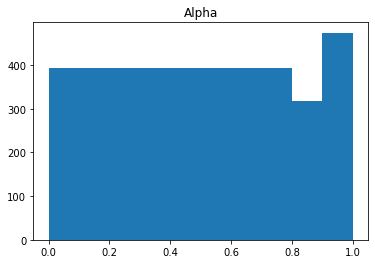

In [42]:
# PLotting frequency of alpha

plt.hist(min_param['alpha'])
plt.title('Alpha')

Text(0.5, 1.0, 'Beta')

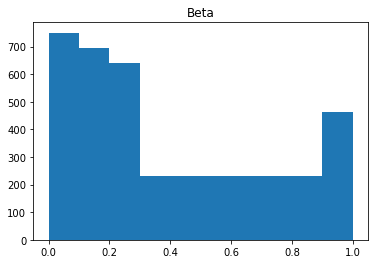

In [43]:
# PLotting frequency of beta

plt.hist(min_param['beta'])
plt.title('Beta')

### Heatmaps

In [44]:
# Function to make heatmaps

def make_heatmap(player_no):
    temp_player = pd.DataFrame(index=alpha_range, columns=beta_range) # Creating empty dataset
    
    # Creating table to make heatmap
    for i in range(len(col)): 
        alpha = float(col[i][0])
        beta  = float(col[i][1])
        temp_player.loc[alpha, beta] = avg_error1[col[i]][player_no]
    temp_player = temp_player.astype(float)
    
    # Creating heatmap
    ticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    sns.set(rc = {'figure.figsize':(30,30)})
    sns.heatmap(data=temp_player, cmap="Blues", 
                      vmin=0, vmax=1, xticklabels=ticks, yticklabels=ticks,
                      #cbar=False, annot=True, linewidths=.5
                     ).set(ylabel='Alpha', xlabel='Beta', title=(error1['player'].unique())[player_no])

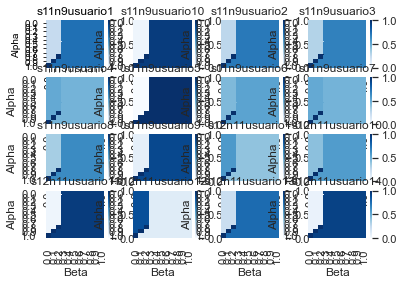

In [45]:
for i in range(number_of_participants//6):
    plt.subplot(no_of_cols, no_of_rows, i+1)
    make_heatmap(i)
    
plt.show()

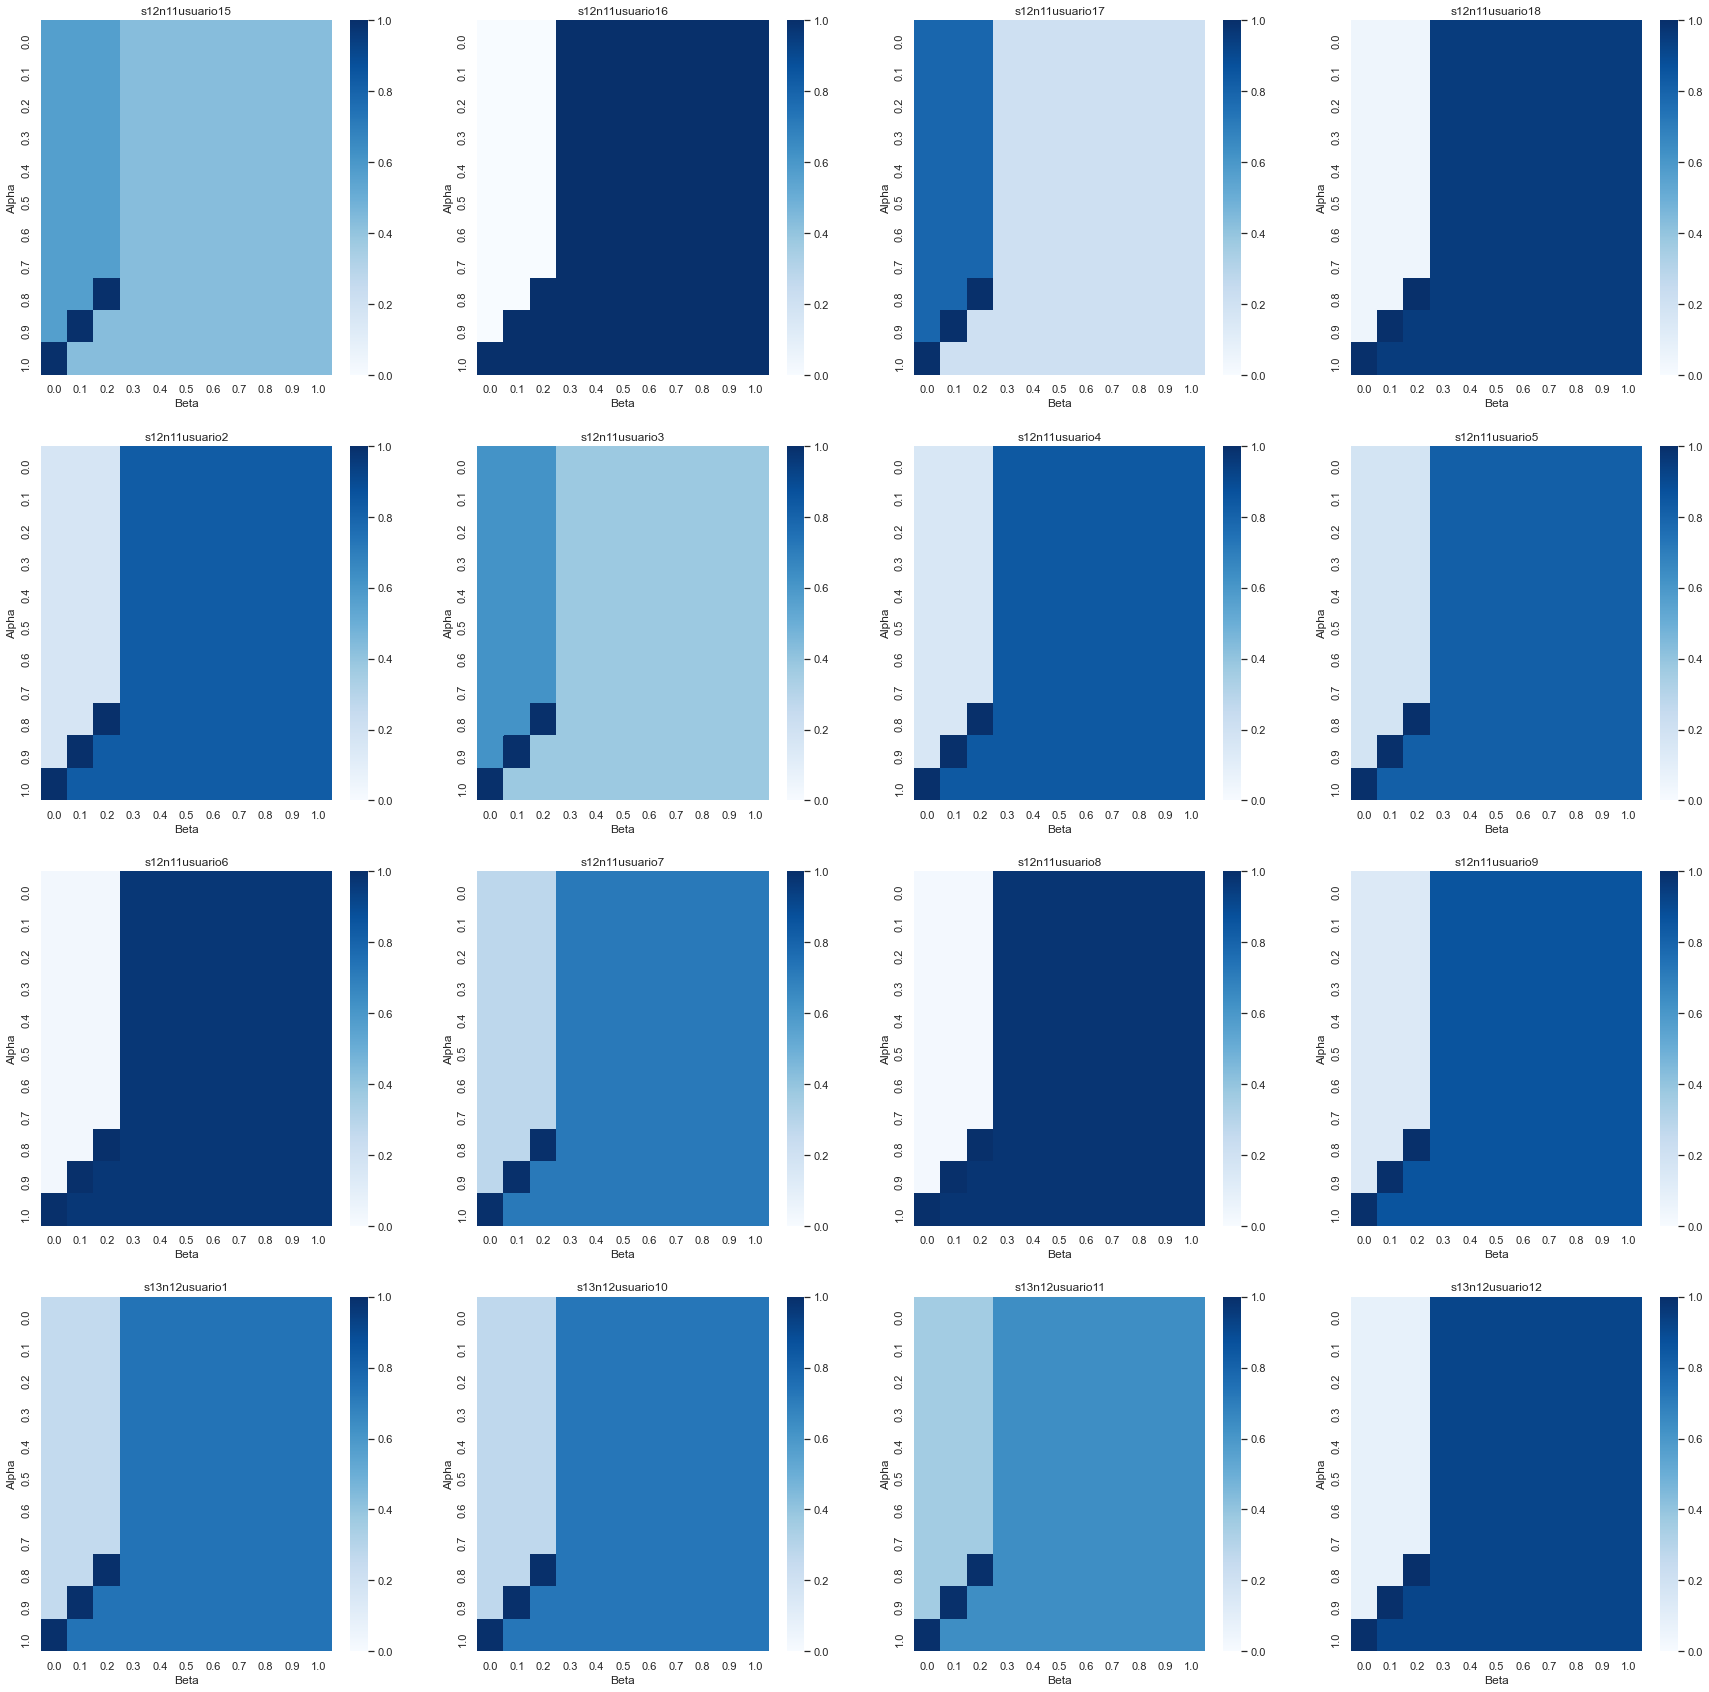

In [46]:
for i in range(number_of_participants//6):
    plt.subplot(no_of_cols, no_of_rows, i+1)
    make_heatmap(i+16)
    
plt.show()

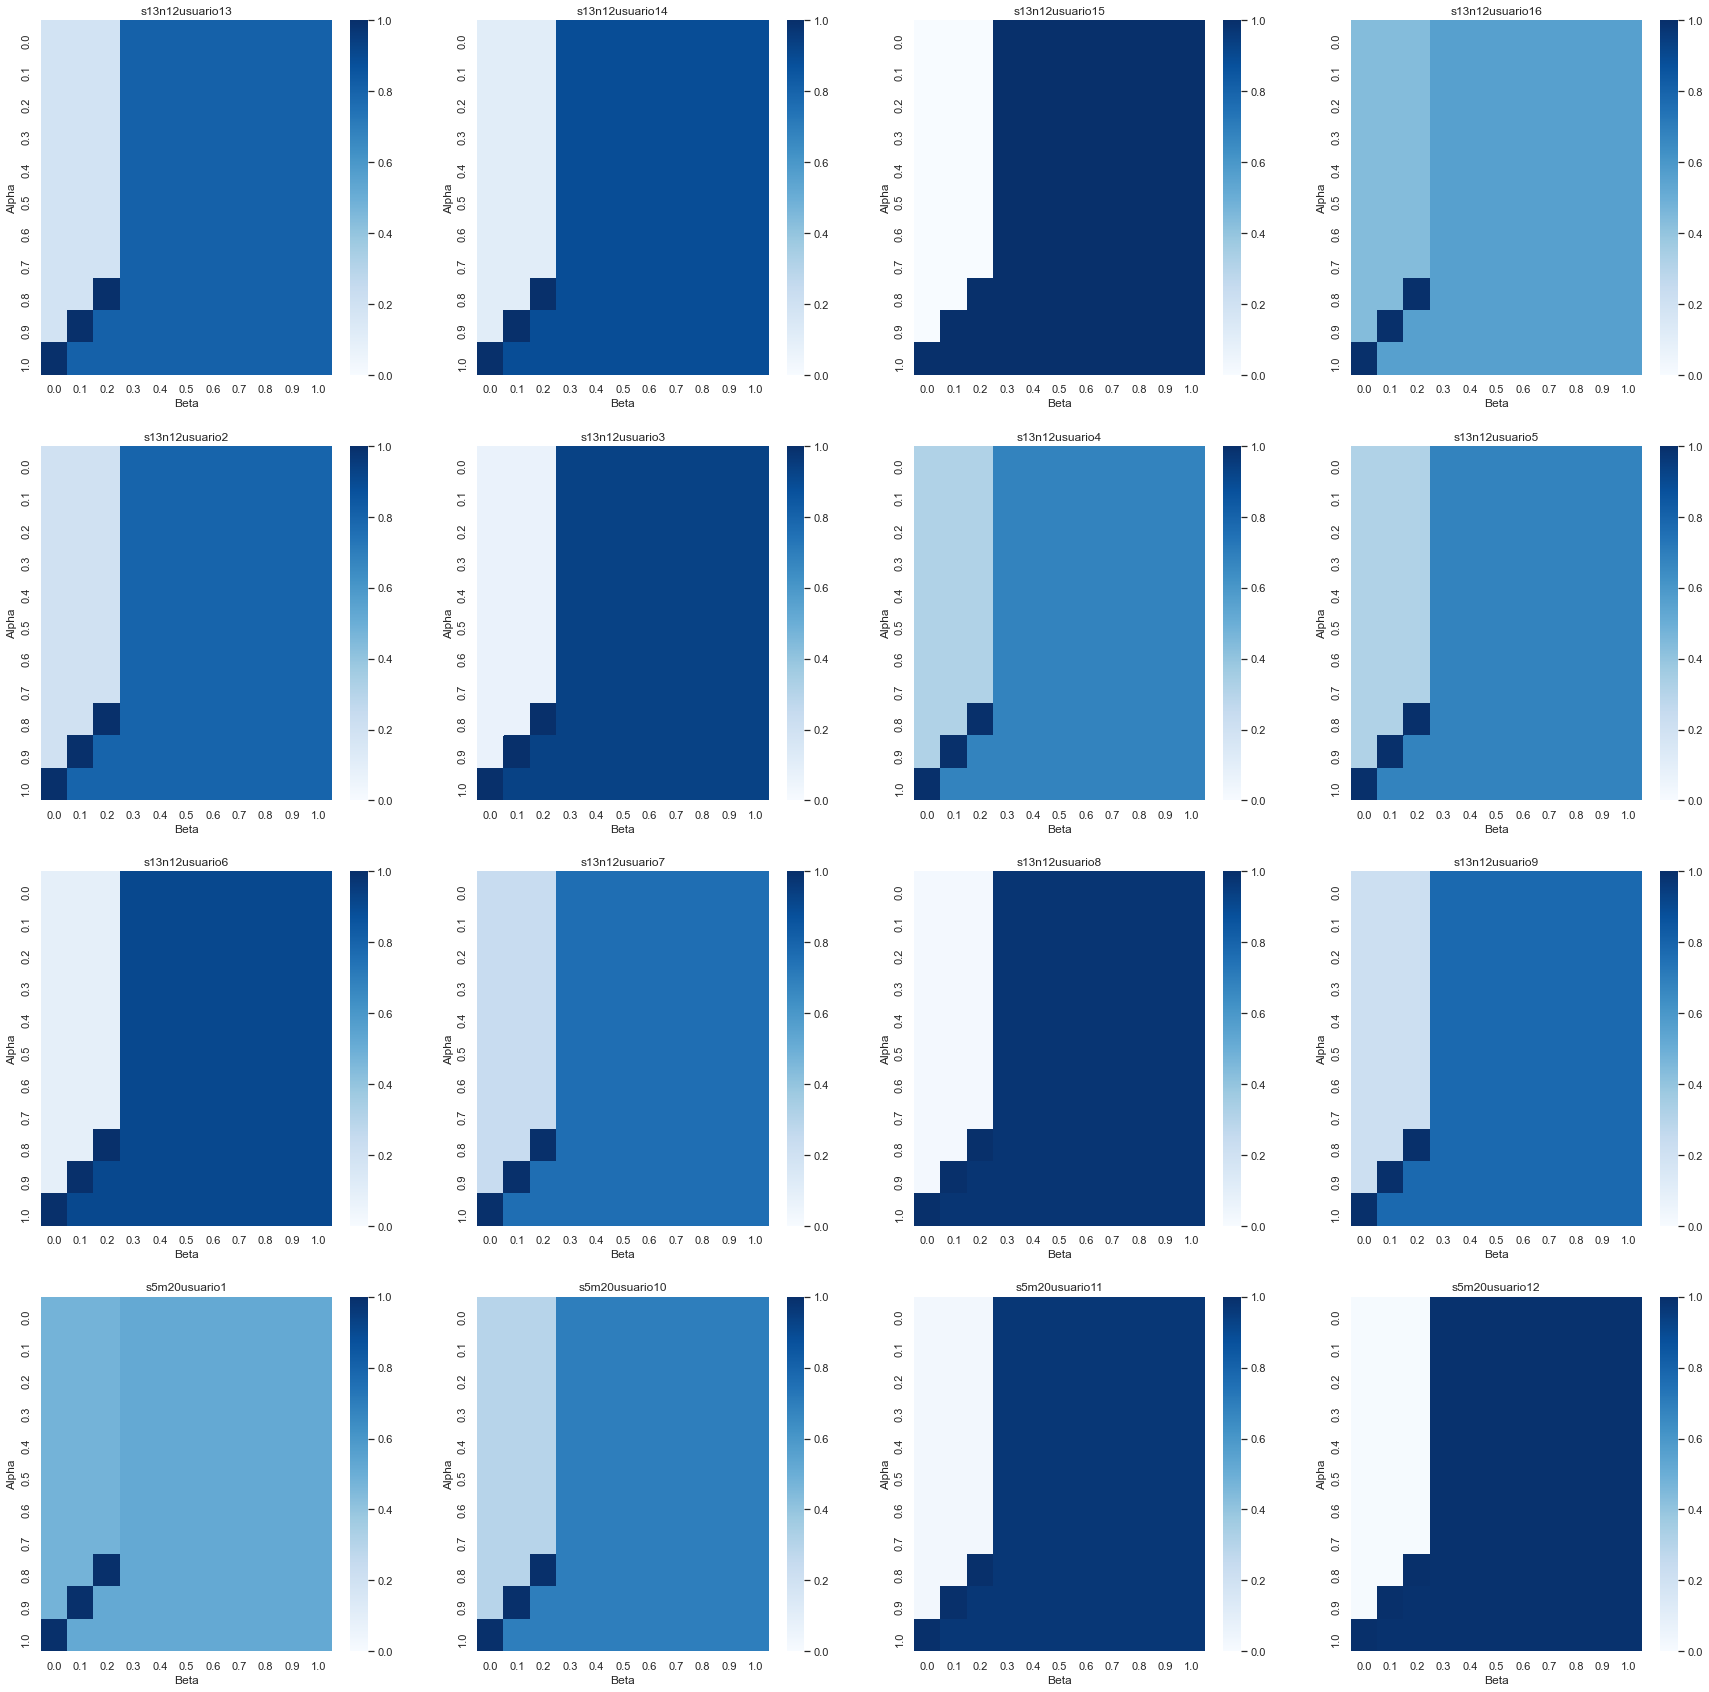

In [47]:
for i in range(number_of_participants//6):
    plt.subplot(no_of_cols, no_of_rows, i+1)
    make_heatmap(i+32)
    
plt.show()

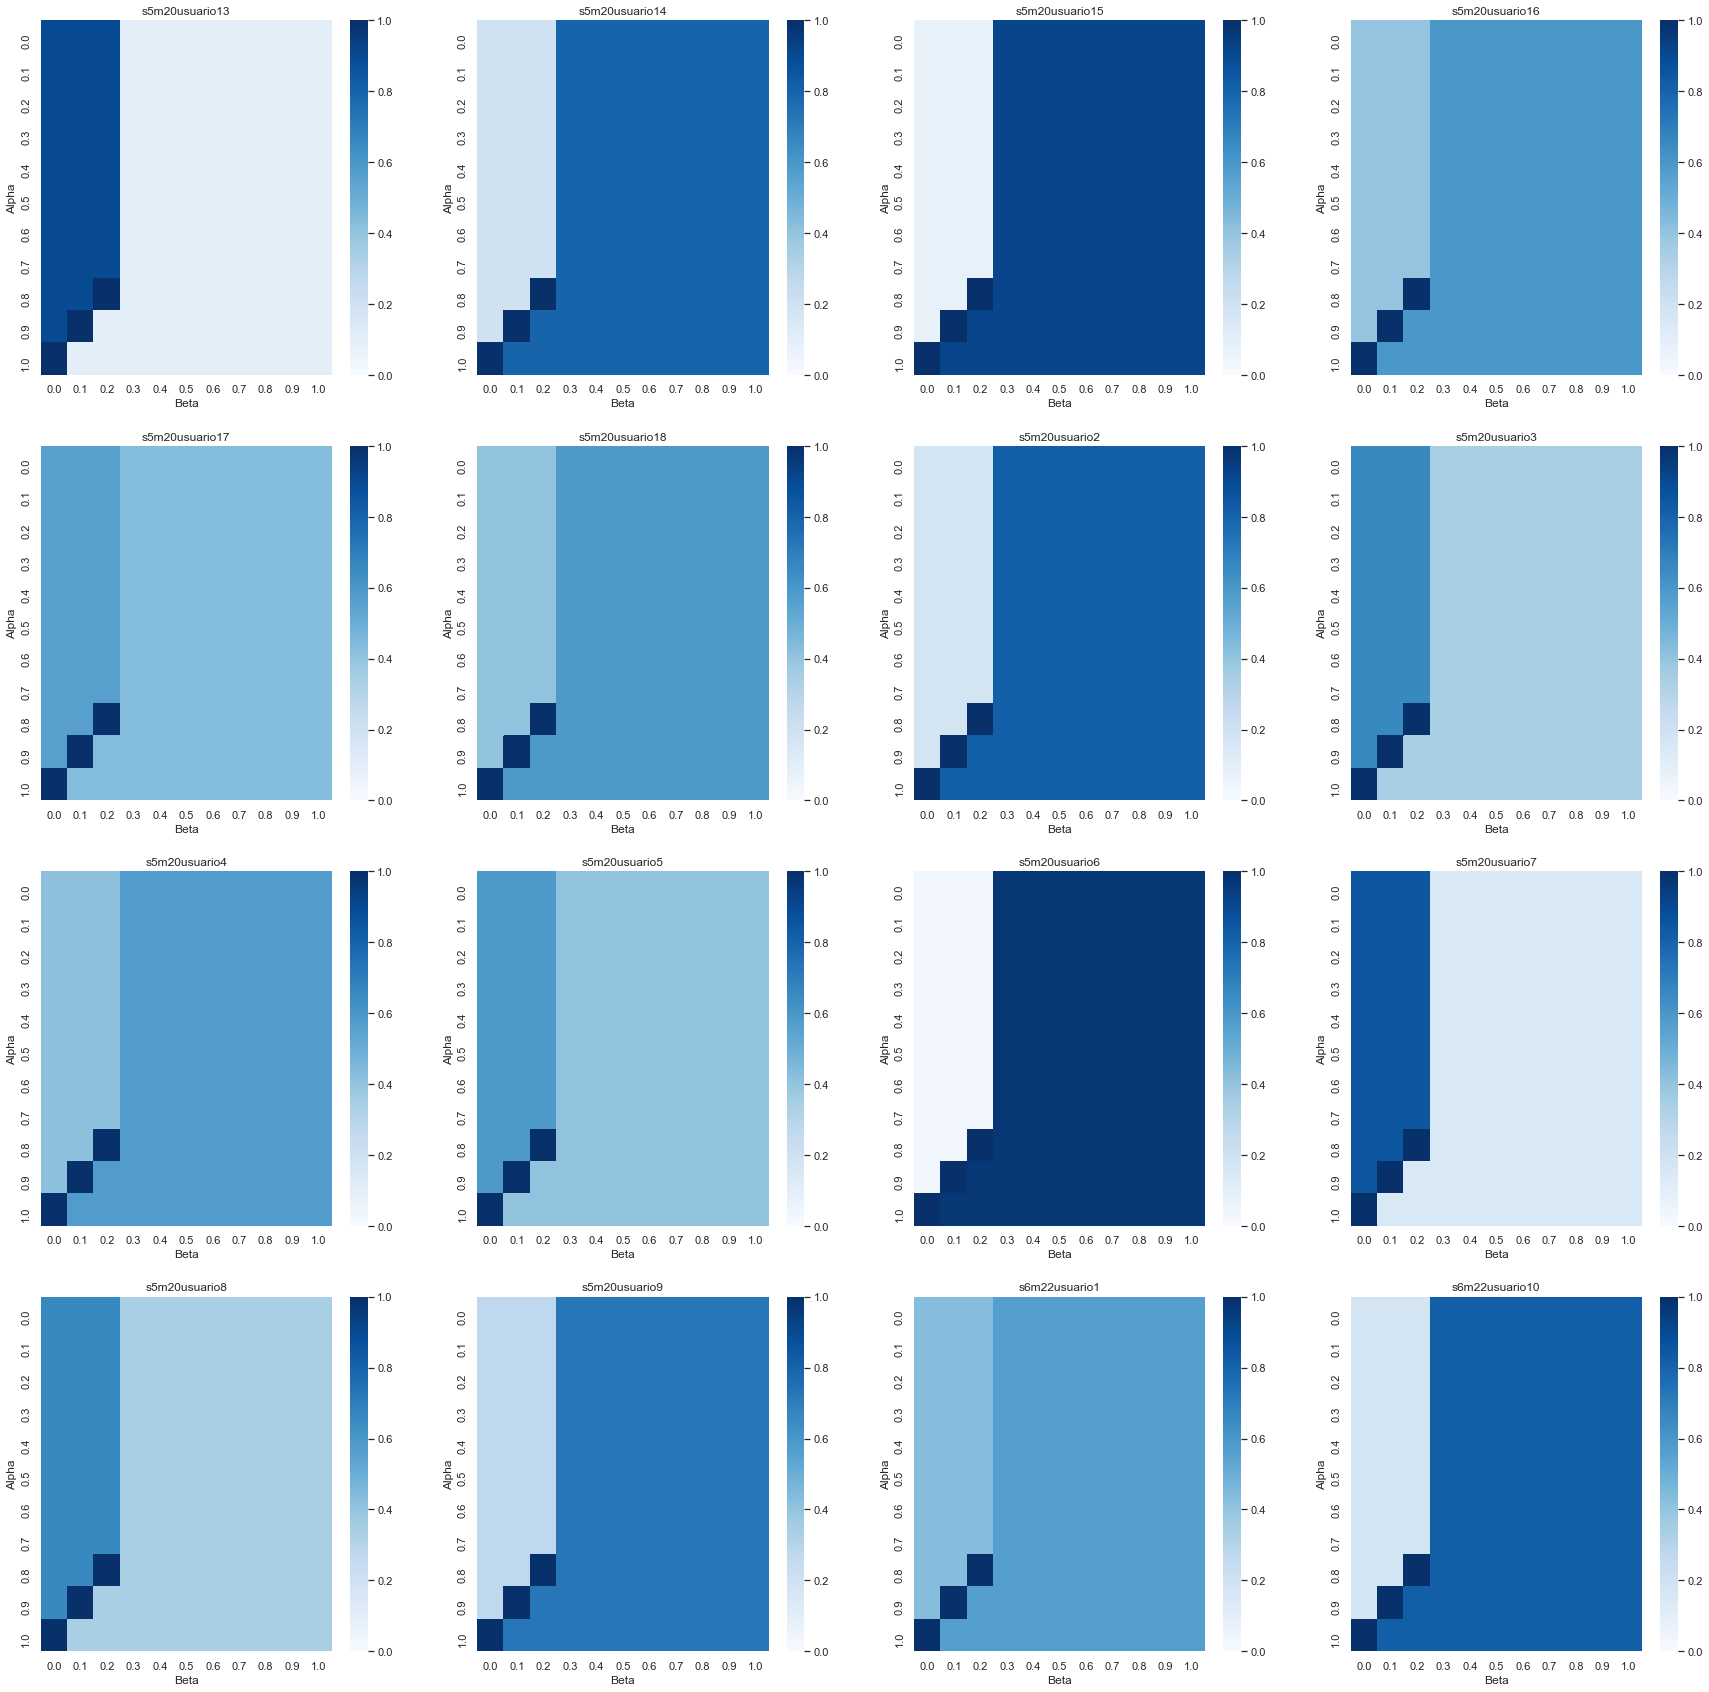

In [48]:
for i in range(number_of_participants//6):
    plt.subplot(no_of_cols, no_of_rows, i+1)
    make_heatmap(i+48)
    
plt.show()

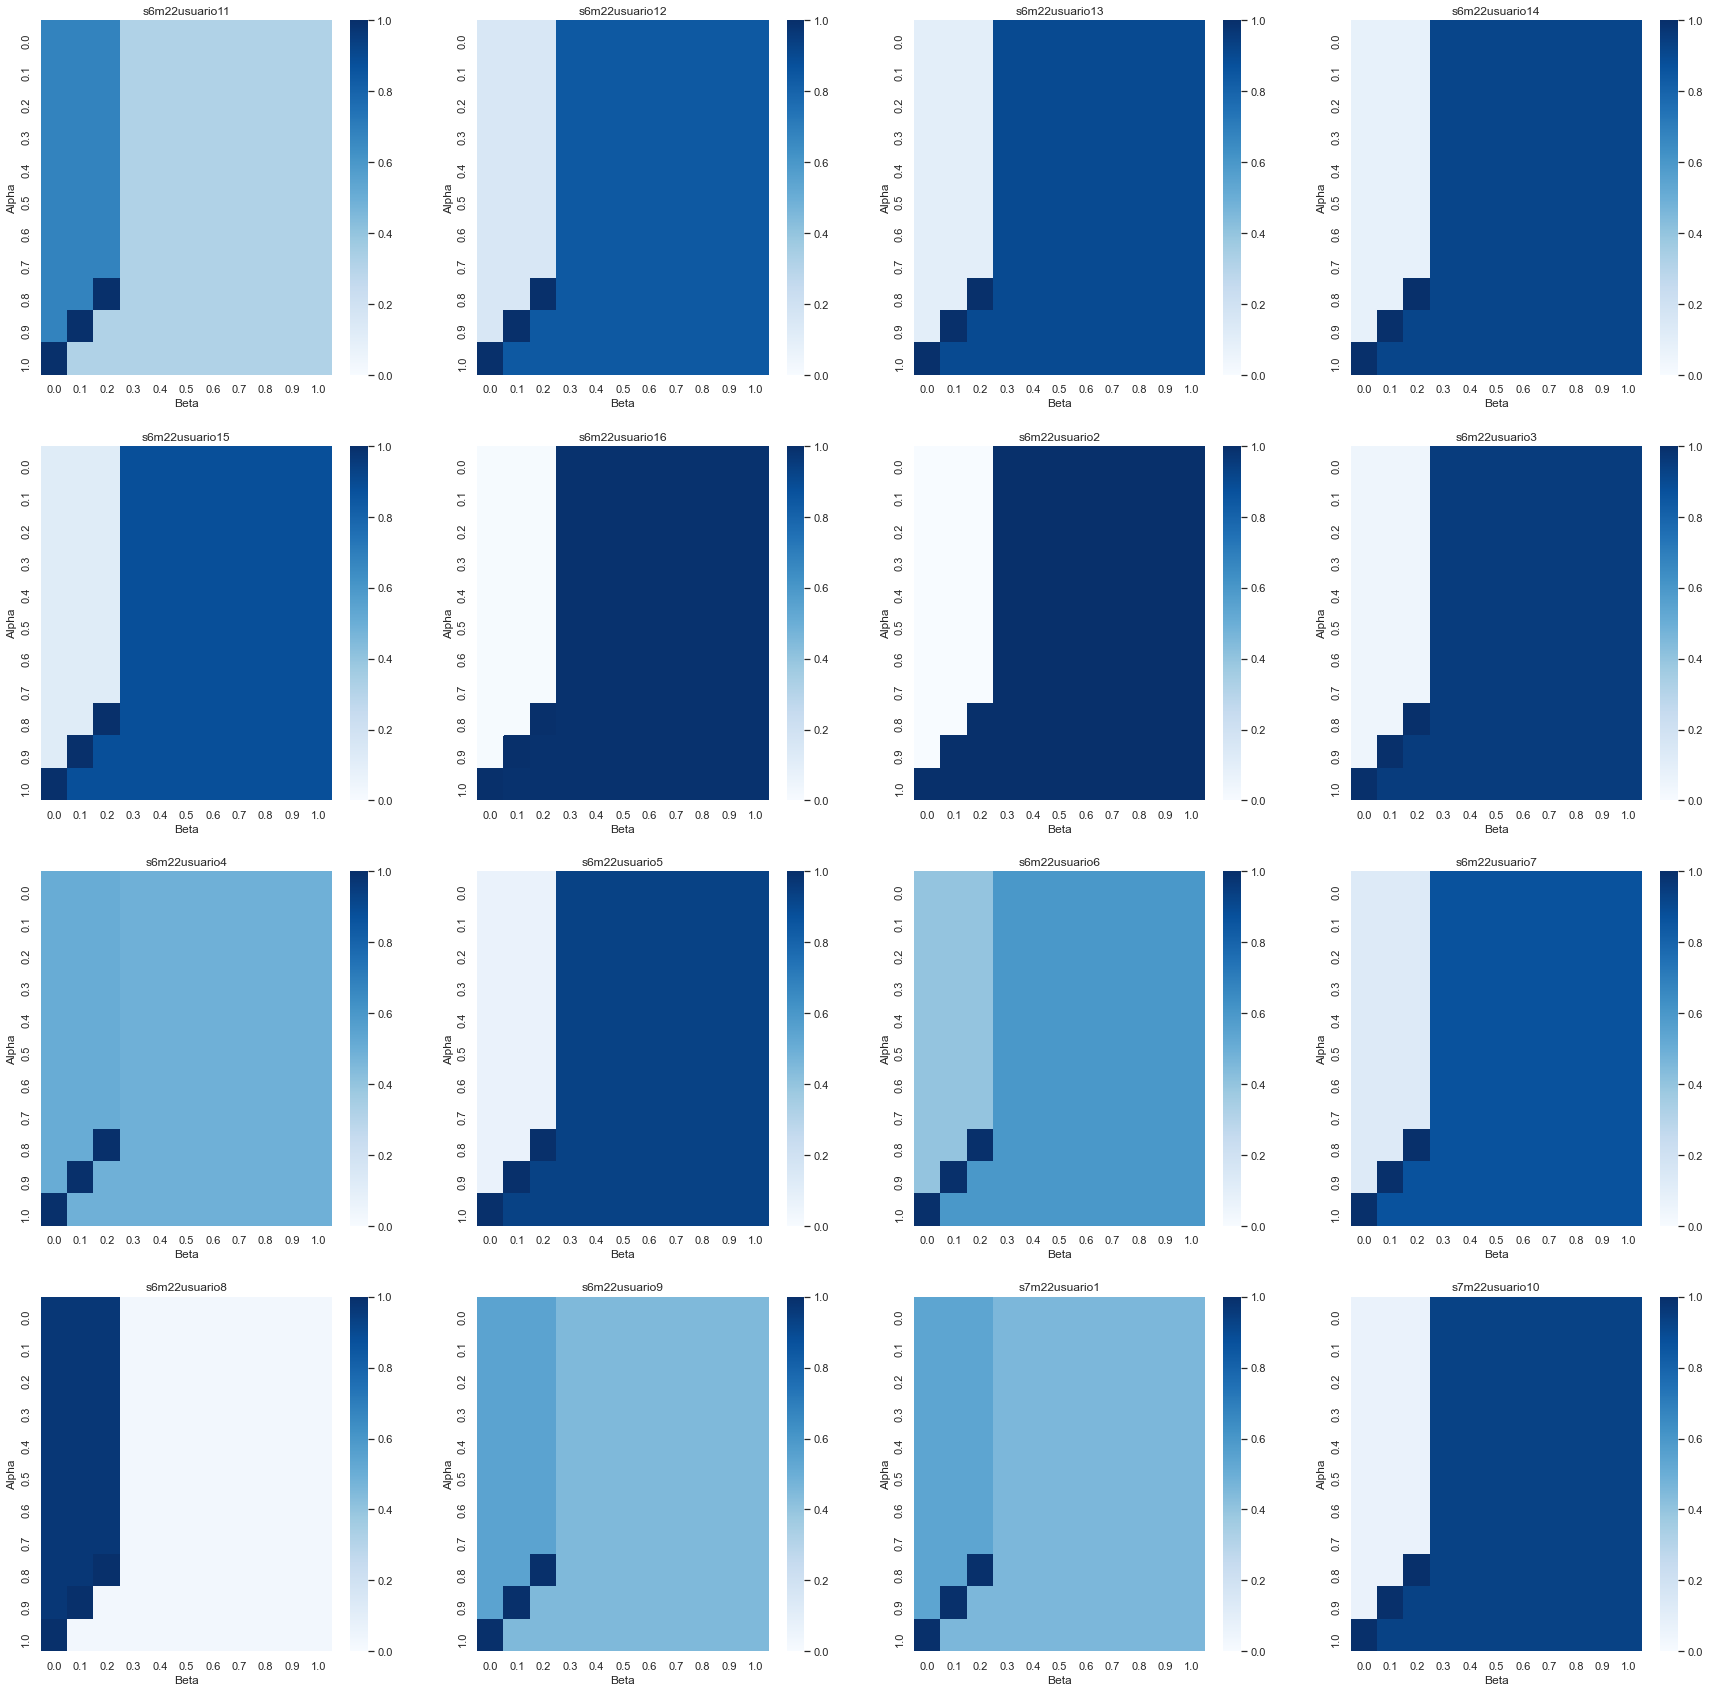

In [49]:
for i in range(number_of_participants//6):
    plt.subplot(no_of_cols, no_of_rows, i+1)
    make_heatmap(i+64)
    
plt.show()

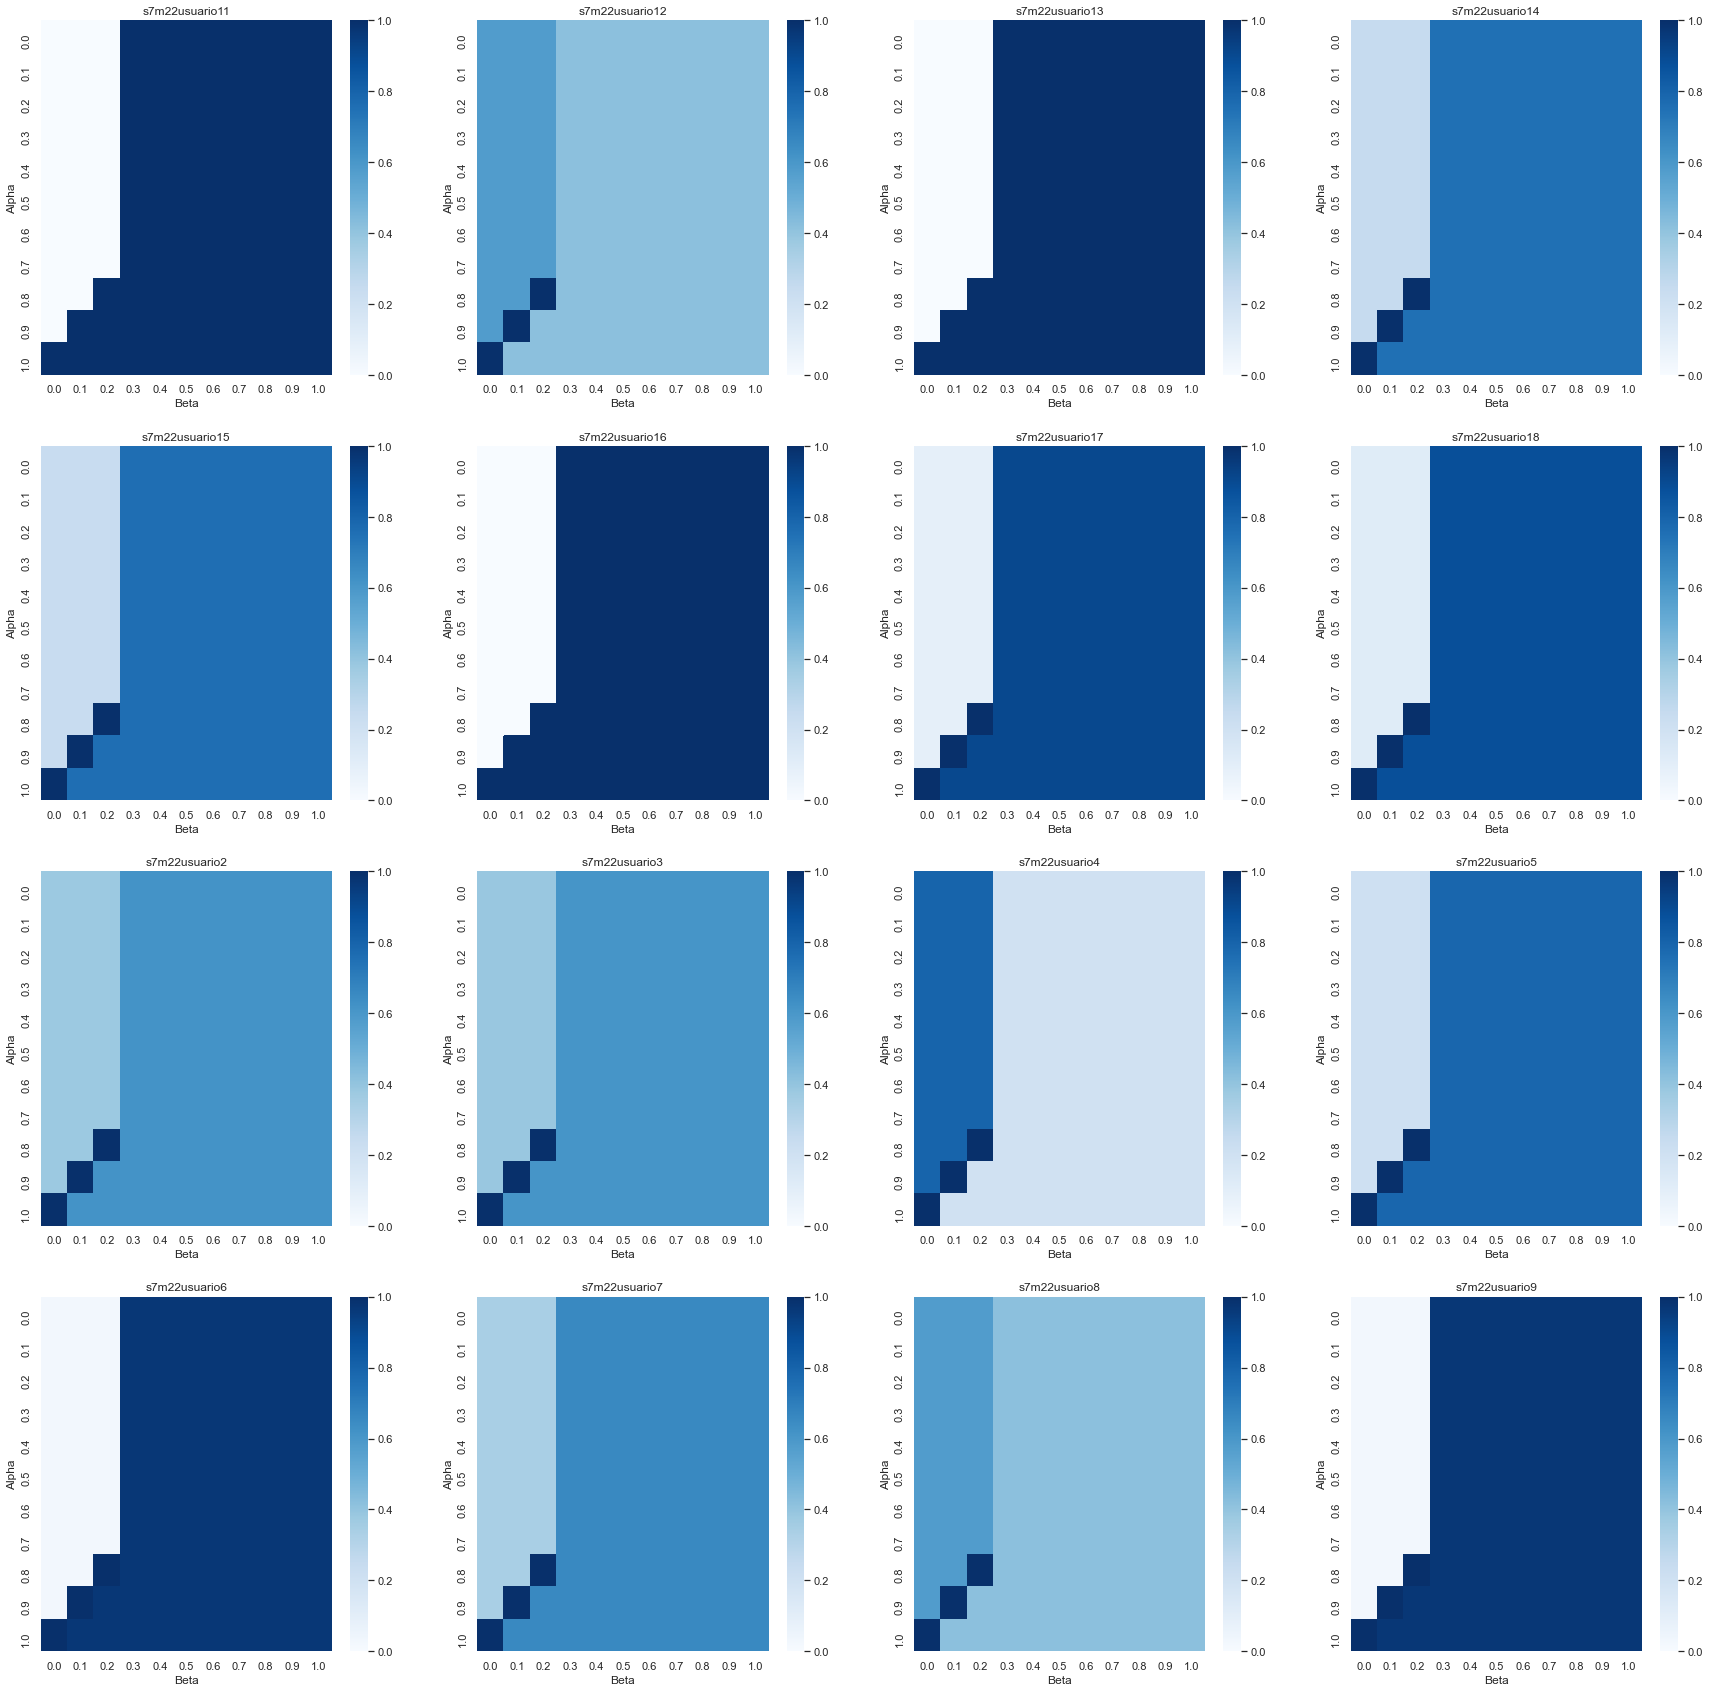

In [50]:
for i in range(number_of_participants//6):
    plt.subplot(no_of_cols, no_of_rows, i+1)
    make_heatmap(i+80)
    
plt.show()

#### Regressions:

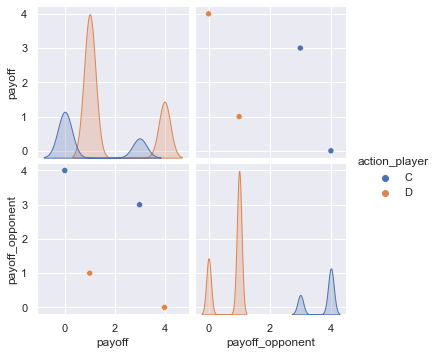

In [51]:
# Pair plot:
sns.pairplot(df[['action_player', 'action_opponent', 'payoff', 'payoff_opponent']], hue='action_player')

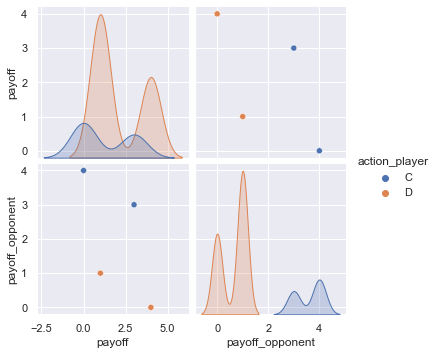

In [52]:
# Pair plot for player 1:
sns.pairplot(df[['action_player', 'action_opponent', 'payoff', 'payoff_opponent']][df['player']==df.loc[0, 'player']], hue='action_player')

In [53]:
import statsmodels.formula.api as smf

In [54]:
# Logistic regression for player 1:

reg = pd.DataFrame(index=df['action_player'][df['player']==df.loc[0, 'player']].index, columns=['C_dummy', 'payoff', 'payoff_opponent'])
reg['C_dummy'] = pd.get_dummies(df['action_player'][df['player']==df.loc[0, 'player']])
reg[['payoff', 'payoff_opponent']] = df[['payoff', 'payoff_opponent']][df['player']==df.loc[0, 'player']]

formula = 'C_dummy ~ payoff'# + payoff_opponent'
log_reg = smf.logit(formula, data=reg).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.527103
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                C_dummy   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Tue, 22 Nov 2022   Pseudo R-squ.:                 0.06265
Time:                        14:32:44   Log-Likelihood:                -52.710
converged:                       True   LL-Null:                       -56.234
Covariance Type:            nonrobust   LLR p-value:                  0.007942
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3667      0.349     -1.051      0.293      -1.051       0.317
payoff        -0.4562      0.187     -2.434      0.015      -0.824      -0.089
==============================================================================
"""

# Level 2

Level 2: participant has unknown alpha and beta, opponent also has unknown alpha and beta values, which participant estimates.

Assumption: Let the estimates be $\alpha_2$ and $\beta_2$

Payoff matrix:


| Player\Opponent | C        | D    |
| ------          | ----- | ---- |
| **C**           | $(3, 3)$     | $$(4\alpha_1, 4(1-\beta_2))$$ |
| **D**           | $$(4(1-\beta_1), 4\alpha_2)$$     | $$(1, 1)$$ |

If player 2 plays C, best response of player 1 is

$$
    \text{best response} = 
    \begin{cases}
        C & \mbox{if } \beta > 0.25\\
        D & \mbox{if } \beta < 0.25\\
        \{C, D\} & \mbox{if } \beta = 0.25
    \end{cases}
$$

And if player 2 plays D, best response of player 1 is

$$
    \text{best response} = 
    \begin{cases}
        C & \mbox{if } \alpha > 0.25\\
        D & \mbox{if } \alpha < 0.25\\
        \{C, D\} & \mbox{if } \alpha = 0.25
    \end{cases}
$$

Broadly there will be four types of players (this time types are in terms of beliefs of the player about the opponent's alpha and beta), low-$\alpha$ low-$\beta$ type, low-$\alpha$ high-$\beta$ type, high-$\alpha$ low-$\beta$ and high-$\alpha$ high-$\beta$ type. And each will have their own equilibrium strategy.

Redo
-----

1) For the low-low type, playing D is the dominant strategyand for the high-high type, dominant strategy is C
2) For low-high and high-low types there are two pure strategy Nash equilibria and one mixed strategy.

Again assume that the players choose actions such that the equilibrium with higher payoff is achieved.

Now, for low-high type, the equilibria are (C, C) and (D, D), first gives the player a payoff of 3 and the second gives 1. So low-high type will play C. For high-low type, the equilibria are (C, D) and (D, C) which give respective payoffs, $4\alpha$ and $4(1-\beta)$. Thus, if $\alpha+\beta>1$ player will play C and the opponent will play D and vice versa in the other case.

(Add this alpha-beta strategy graph using latex later)

In [55]:
col2 = []

for alpha1 in alpha_range:
    for beta1 in beta_range:
        for alpha2 in alpha_range: 
            for beta2 in beta_range: 
                name = str(alpha1), str(beta1), str(alpha2), str(beta2)
                col2  = col2 + [name]

In [56]:
# Create empty dataframes
action2 = pd.DataFrame(index=df.index, columns=col2)    # utility matrix
error2  = pd.DataFrame(index=df.index, columns=col2)    # error matrix

In [57]:
# Utility Grid

for i in range(len(col2)):
    beta = float(col[i][1]) # convert beta (from column name) from string to float
    if beta < 0.25:
        action2.iloc[:, i] = 'D'
    if beta > 0.25:
        action2.iloc[:, i] = 'C'
        
#action2.head()

IndexError: list index out of range

In [ ]:
# Calculating error matrix

for x in col:
    error2[x] = action2[x]==df['action_player']
    
error2 = 1 - error2 # Converting to ones and zeros from trues and falses
error2['player'] = df['player'] # Adding player column for easier future calculations

#error2.head()

In [ ]:
# Calculate average error for each participant

data = []

for i in df['player'].unique():
    sum_of_error = (error2[error2['player']==i].iloc[:,:-1]).sum() # summing over error rows where player == i and taking every column except the last (which is the name column) using iloc
    number_of_trials = (df['player']==i).sum()
    data = data + [sum_of_error/number_of_trials]
    
avg_error2 = pd.DataFrame(data=data)

#avg_error2.head()

In [ ]:
# Calculating fraction of players in the lower alpha bracket

frac = sum(avg_error2.iloc[:, 0]<=0.5)/number_of_participants # sum of rows of first column of avg_error which are less than 0.5 divided by no of participants
frac # taking less than 0.5 because the other error is compliment of this (check avg_error df)

In [ ]:
fig, ax = plt.subplots()

pt1 = sns.histplot(x=avg_error2.iloc[:, 0], ax=ax) # when alpha is in the lower bracket
pt2 = sns.histplot(x=avg_error2.iloc[:, -1], ax=ax, color='red') # in the higher bracket
plt.title('Level 2: Distribution of error')
plt.xlabel('Error')

# Level 3

Level 3: participant has unknown alpha and beta, opponent also has unknown alpha and beta values, which participant estimates, and opponent has estimates of participant's alpha and beta, which the participant also estimates.

In [ ]:
#col2